In [1]:
import sys
print("Python Version")
print(sys.version)

Python Version
3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Import required packages

# Python Standard Packages

import re
import pickle

# External Packages
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For model building
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Activation, Embedding
from keras.utils import np_utils

# For model selection & evaluation
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# For text cleaning & preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize, word_tokenize, pos_tag
from bs4 import BeautifulSoup  

# For ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

# To generate word2vec embeddings
from gensim.models import word2vec, Word2Vec
from gensim.models.keyedvectors import KeyedVectors

# Generating WordClouds
import wordcloud
from wordcloud import WordCloud

nltk.download("punkt")
nltk.download('stopwords')
nltk.download("vader_lexicon")

[nltk_data] Error loading punkt: [WinError 10060]
[nltk_data]     由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
dataset_path = "Training.xlsx"
data_df = pd.read_excel(dataset_path, lines=True)
data_df.sample(5)

,code,label
646,+\n,2
1784,+\n,3
1075,+ } else {\n,3
2731,+ \ttry {\n,4
1291,+ if (data != null) {\n,3


In [4]:
# Summary of Numerical Features
data_df.describe()

,label
count,2839.000000
mean,2.492427
std,1.037627
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,4.000000


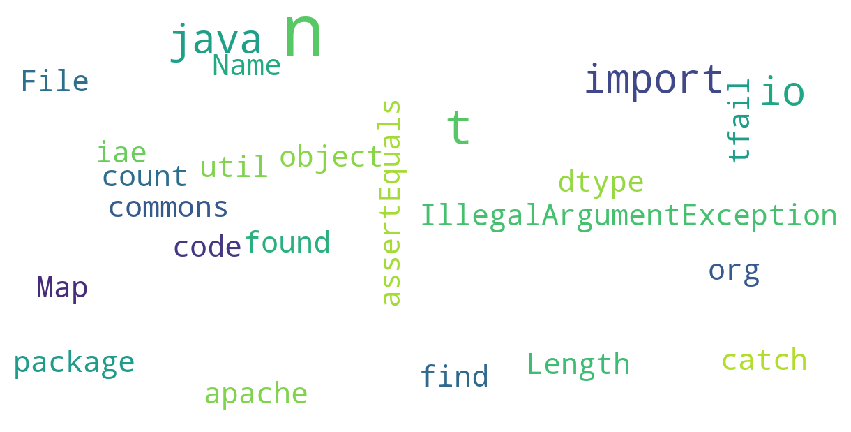

In [5]:
# See what kind of words appear in the dataset

def plot_wordcloud(data):

    wordcloud = WordCloud(random_state = 42,max_words = 200,background_color = 'white',max_font_size = 35,scale = 3)
    wordcloud = wordcloud.generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

plot_wordcloud(data_df["code"])

In [6]:
# Split train & test data in ratio 7:3 in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(data_df['code'], data_df['label'], test_size=0.3, random_state=0, stratify=data_df['label'])

print(f"Count of training examples: {X_train.shape[0]}")
print(f"Count of test examples: {X_test.shape[0]}")

Count of training examples: 1987
Count of test examples: 852


In [7]:
def cleanCode(Code, remove_stopwords=False, stemming=False, split_text=False):

    Code = BeautifulSoup(Code, 'lxml').get_text()
    Code = re.sub("[^a-zA-Z]", " ", Code) 
    Code = Code.lower().split()
    
    if remove_stopwords:
        Code = [w for w in Code if not w in set(stopwords.words("english"))]
        
    if stemming:
        Code = [SnowballStemmer('english').stem(w) for w in Code]
        
    if split_text:
        return Code
    else:
        return(" ".join(Code))

X_train_cleaned = [cleanCode(Code) for Code in X_train]
X_test_cleaned = [cleanCode(Code) for Code in X_test]

In [8]:
# Extract sentences from Code in training set

def extract_sentences(Code, tokenizer, remove_stopwords=False):

    sentences = tokenizer.tokenize(Code.strip())
    sentences = [cleanCode(sentence, remove_stopwords, split_text=True) for sentence in sentences if len(sentence) > 0]
    return sentences

sentences = []
punkt_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
for Code in X_train_cleaned:
    sentences += extract_sentences(Code, punkt_tokenizer)

In [9]:
embed_size = 128  #embedding dimension                     
w2v = Word2Vec(sentences, workers=4, size=embed_size, min_count = 10,window = 10, sample = 1e-3)
w2v.init_sims(replace=True)
w2v.save("w2v")

In [10]:
def transformedFeatures(Code, w2v_model, embed_size=128):

    vocabulary = set(w2v_model.wv.index2word)
    feat = np.zeros((embed_size,),dtype=float)

    count = 0
    flag = True
    for word in Code:

        if word in vocabulary: 

            count = count + 1.
            feat = np.add(feat, w2v_model[word])
            flag = False

    if flag == False:
        feat = np.divide(feat, count)

    return feat


def transformCodes(Codes, model, embed_size):

    num_Codes = len(Codes)
    
    transformedCodeFeat = np.zeros((num_Codes,embed_size),dtype=float)
    for idx, Codes in enumerate(Codes):
        transformedCodeFeat[idx] = transformedFeatures(Code, model,embed_size)

    return transformedCodeFeat

In [11]:
# Pre-process Training Codes
X_train_cleaned = [cleanCode(Code, remove_stopwords=True, split_text=True) for Code in X_train]
train_vectors = transformCodes(X_train_cleaned, w2v, embed_size)

In [12]:
# Load trained Word2Vec model
X_test_cleaned = [cleanCode(Code, remove_stopwords=True, split_text=True) for Code in X_test]
test_vectors = transformCodes(X_test_cleaned, w2v, embed_size)

In [13]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v")
embedding_matrix = np.array(w2v.wv.syn0)
print("Shape of embedding matrix : ", embedding_matrix.shape)

Shape of embedding matrix :  (154, 128)


In [14]:
# Fit tokenizer on training set and then transform training and test codes

tokenizer = Tokenizer(nb_words=embedding_matrix.shape[0])
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(train_seq, maxlen=20)
X_test_seq = sequence.pad_sequences(test_seq, maxlen=20)
y_train_seq = np_utils.to_categorical(y_train, 5)
y_test_seq = np_utils.to_categorical(y_test, 5)

In [15]:
# Model: Bidirectional LSTM with Word2Vec Embeddings

model = Sequential(
    [Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix]),
   Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.2)),
   Dense(5),
  Activation('softmax')]
)

model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         19712     
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2625536   
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 2,650,373
Trainable params: 2,650,373
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile & train model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=10, validation_split = 0.1, verbose=1)

Epoch 1/10
56/56 [==============================] - 32s 525ms/step - loss: 0.4159 - accuracy: 0.5991 - val_loss: 0.3441 - val_accuracy: 0.6482
Epoch 2/10
56/56 [==============================] - 29s 513ms/step - loss: 0.3450 - accuracy: 0.6238 - val_loss: 0.2741 - val_accuracy: 0.7136
Epoch 3/10
56/56 [==============================] - 29s 513ms/step - loss: 0.2762 - accuracy: 0.7006 - val_loss: 0.2583 - val_accuracy: 0.7136
Epoch 4/10
56/56 [==============================] - 29s 511ms/step - loss: 0.2560 - accuracy: 0.7235 - val_loss: 0.2847 - val_accuracy: 0.7337
Epoch 5/10
56/56 [==============================] - 28s 507ms/step - loss: 0.2638 - accuracy: 0.7142 - val_loss: 0.2465 - val_accuracy: 0.7387
Epoch 6/10
56/56 [==============================] - 28s 506ms/step - loss: 0.2364 - accuracy: 0.7566 - val_loss: 0.2362 - val_accuracy: 0.7688
Epoch 7/10
56/56 [==============================] - 29s 522ms/step - loss: 0.2240 - accuracy: 0.7667 - val_loss: 0.2213 - val_accuracy: 0.7889

In [17]:
# Evaluate trained model
_, test_accuracy = model.evaluate(X_test_seq, y_test_seq, batch_size=32)
print(f'Test accuracy : {round(test_accuracy,4)}')

27/27 [==============================] - 2s 83ms/step - loss: 0.2313 - accuracy: 0.7664
Test accuracy : 0.7664


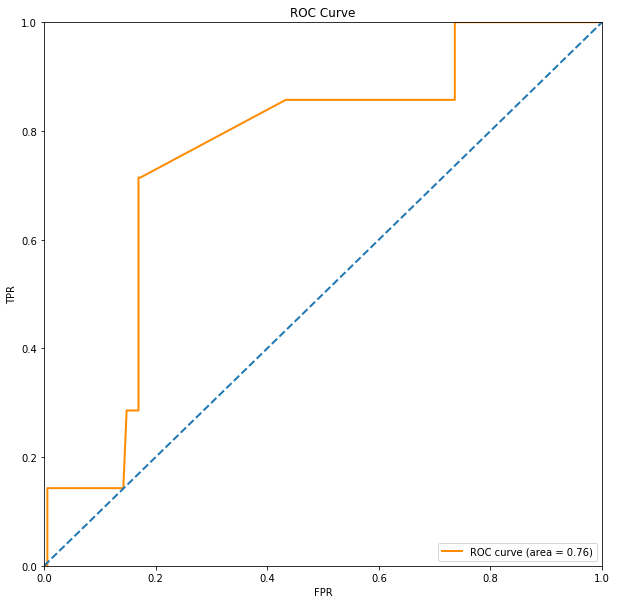

In [18]:
#Receiver Operating Characterstic

y_pred = [x[1] for x in model.predict_proba(X_test_seq)]
y_test = [x.index(1) for x in y_test_seq.tolist()]

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {round(roc_auc,2)})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

In [19]:
# Saving Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save model architecture by serializing to JSON
json_model = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(json_model)

# Save model weights by serializing to HDF5
model.save_weights("model.h5")